In [3]:
from __future__ import division
import numpy as np
import scipy.fftpack as sf
import matplotlib.pyplot as plt
import math
import pylab as pl
import scipy.signal as sig
from scipy import misc

## 1. STFT  (Short Time Fourier Transform) and source separation.

## In this part, we use STFT which is a collection of Fourier transform of a 1D signal on time subintervals. Why using STFT ?
- The length of a music signal for 4 minutes sampled at a rate of 44kHz is roughly $2500*44000 \simeq 1.1 \times 10^7$.
- The length of a music note is of the order of a tenth of a second.
### Conclusion: do not use FFT on the whole signal but on short segments of it.

### We use it in order to experiment source separation which comes from the idea that the different signals may present very different behaviour in the frequency domain.

In [4]:
# utils to load the sounds.
import numpy as np
import wave as wv

def load_sound(file, n0):
    
    x_raw = wv.open(file)
    n = x_raw.getnframes()
    x = np.frombuffer(x_raw.readframes(-1), 'Int16')
    x_raw.close()
    
    if file[::-1][:8][::-1] == "bird.wav":
        x = np.delete(x,list(range(6001)) + list(range(12500, 15001)) + list(range(22500, 24001)) + list(range(32500,34001)))

    if n0 !=0 and n0 < n:
        x = x[:n0]
    
    return x/np.max(x)

## Hereafter, we load the $3$ sounds and plot the second one.

In [5]:
n = 1024*16
s = 3 #number of signals.
x = np.zeros([n,3])
x[:,0] = load_sound("bird.wav",n)
x[:,1] = load_sound("female.wav",n)
x[:,2] = load_sound("male.wav",n)

## listen to a sound.
from IPython.display import Audio
Audio(x[:,1], rate = 15000)

c:\users\laurine\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if __name__ == '__main__':


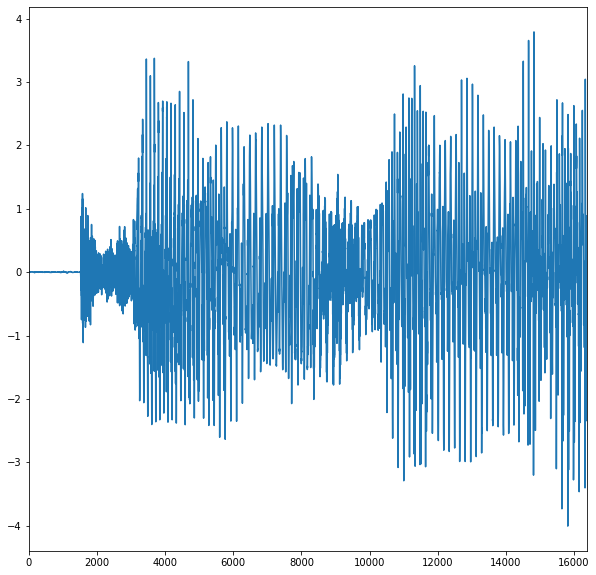

In [6]:
# Show the numerical signal.
x = x/np.tile(np.std(x,0),(n,1))
p = 2 #number of micros
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.xlim(0,n)
plt.plot(x[:,2])
plt.show()

### We simulate two micros which are implemented by linear combinations of the signals.

In [7]:
theta = np.linspace(0, np.pi, s + 1)[:-1]
theta[0] = .2
M = np.vstack((np.cos(theta), np.sin(theta)))
## recorded signals
y = np.dot(x,np.transpose(M))
print("length of the signals",np.shape(y))
# Listen to the two recorded signals.
from IPython.display import Audio
Audio(y[:,1], rate = 15000)

length of the signals (16384, 2)


### We use the STFT function from the python package signal and plot it.

16641


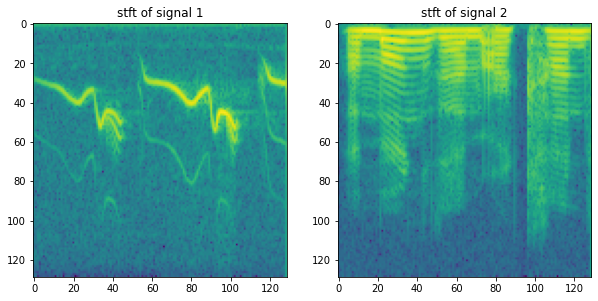

In [8]:
import scipy.signal as sig
f,t,w = sig.stft(x[:,0])
a,b,z = sig.stft(x[:,1])
print(np.size(z))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title("stft of signal 1")
plt.imshow(np.log(np.abs(w)))
plt.subplot(1,2,2)
plt.title("stft of signal 2")
plt.imshow(np.log(np.abs(z)))

### We numerically check that the STFT and ISTFT are indeed inverse from each others.

In [9]:
micro1 = y[:,0]
micro2 = y[:,1]
stft = lambda im : sig.stft(im,noverlap = 64,nperseg = 128)
istft = lambda im : sig.istft(im,noverlap = 64,nperseg = 128)
f,t,w1 = stft(micro1)
print(np.shape(w1))
f,t,w2 = stft(micro2)
W = np.asarray([w1.flatten(),w2.flatten()])
print(W)
print(np.shape(W))
t,recov = istft(w1)
print(np.sum((micro1 - recov)**2))

(65, 257)
[[ 1.16144549e-02+0.j  1.61385888e-02+0.j  1.85006418e-02+0.j ...
   1.18385135e-04+0.j  7.66135211e-04+0.j  4.97046266e-03+0.j]
 [ 2.27491165e-03+0.j  6.23925565e-03+0.j  4.34767210e-03+0.j ...
  -3.85635906e-05+0.j  2.08275687e-04+0.j  2.12086109e-03+0.j]]
(2, 16705)
1.01845282578757e-27


### By selecting randomly a group of points in time, we plot in the plane the coordinates of the points, being the measured signals by the micros.

16384


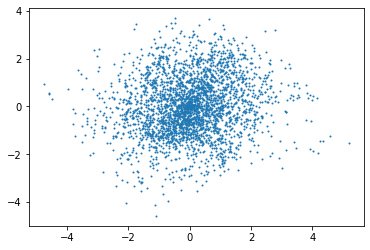

In [19]:
nbre_selec = 3000
from random import shuffle
print(np.shape(y)[0])
liste = [ i for i in range(np.shape(y)[0])]
shuffle(liste)
plt.plot(y[liste[0:nbre_selec],0],y[liste[0:nbre_selec],1],"o",markersize=1)
plt.show()

### Q: Do the same with the STFT signals, what do you observe ?

16705


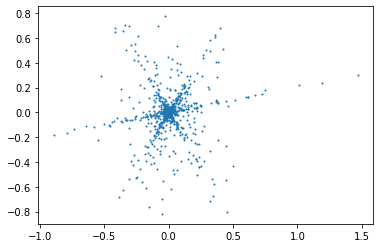

In [20]:
### your code here.

# W represent STFT signals

signal = W
#to have it in the good axis
signal = signal.transpose()
print(np.shape(signal)[0])
stftList = [ i for i in range(np.shape(signal)[0])]
shuffle(stftList)
signal = signal.real
plt.plot(signal[stftList[0:nbre_selec],0],signal[stftList[0:nbre_selec],1],"o",markersize=1)
plt.show()

We observe that points congregates to 3 distincts lines that cross at a central point (the origin). 

### Q: For each point in the plot above, compute its angle (angle between 2 points) and plot the distribution of the angles (use the function np.histogram) and plot it.

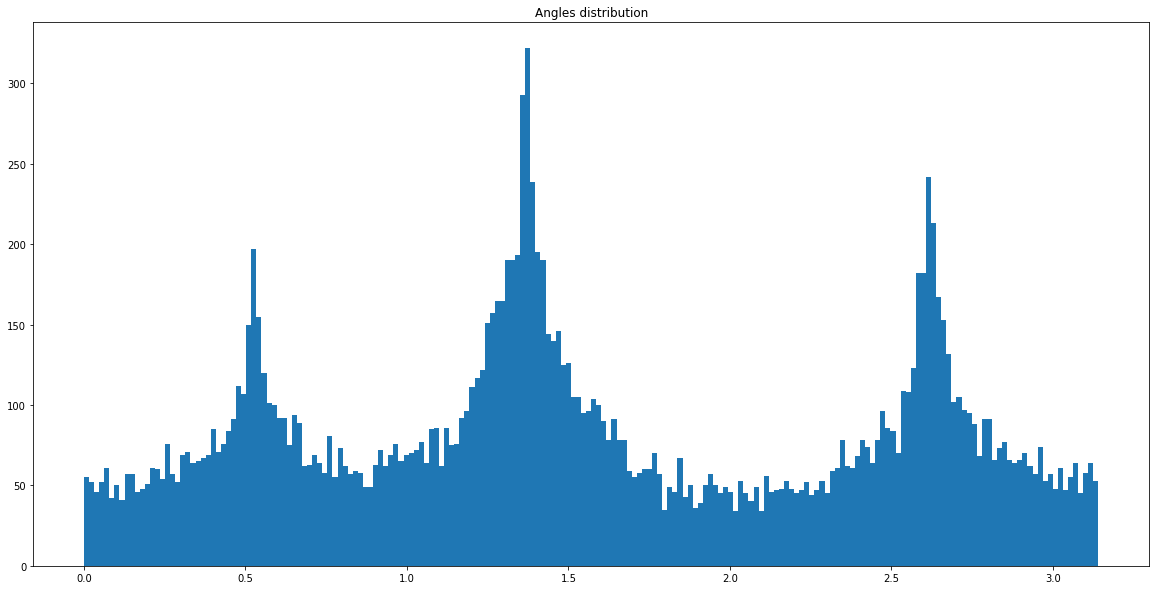

In [24]:
#math.atan2() : Returns the tangent(y,x) in radius.

angles = []

for i in stftList:
    angle = math.atan2(signal[i, 0].real, signal[i, 1].real)
    angle = angle % np.pi #take angle between 0 and pi
    angles.append(angle)
    
plt.figure(figsize=(20,10))
plt.title("Angles distribution")
histogram = plt.hist(angles, bins=200)
plt.show()

### Q: By selecting the highest peaks of the distribution, estimate the angles of the mixing.

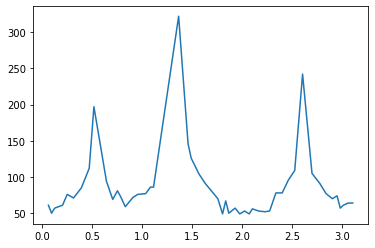

In [37]:
#A bin is range that represents the width of a single bar of the histogram along the X-axis
peakCounts, peakBins = np.histogram(angles, bins=200)
#np.histogram computes the occurrences of input data that fall within each bin
#which in turns determines the area (not necessarily the height if the bins aren't of equal width) of each bar.

peaks, prop = sig.find_peaks(peakCounts)
plt.plot(peakBins[peaks], peakCounts[peaks])
plt.show()

### Q: Using the STFT recorded signals, take each point in the plane and compute its projection on each recovered directions. It gives a vector of 3 estimated projections.

In [31]:
#pour chaque point, angle max des pics, chaque point déterminer angle auquel il appartient
#si point proche angle considéré valeur du point sinon 0

#https://stackoverflow.com/questions/9605556/how-to-project-a-point-onto-a-plane-in-3d

### Q: For each frequency point in the signal STFT, select the direction on which it has the largest projection. And threshold using the code below.

In [25]:

### insert your code here.
#threshold = .005
#D = np.sqrt(np.sum(W**2, 0))
#I = I*(D > threshold)

### Q: Plot the STFT and the time domain of the recovered signals and the original signals. Estimate the performance using the SNR implemented below.

In [28]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

### Q: Listen to the reconstructed signals and the original signals.

In [103]:
i = 0
from IPython.display import Audio
#Audio(X[i], rate = 15000)

In [104]:
i = 0
from IPython.display import Audio
#Audio(x[:,i], rate = 15000)

# 2. The goal of this part is to explore implementations of a FIR or an IIR.

## We plot below a signal with a mix of low and high frequencies.

(1000,) (1000,)


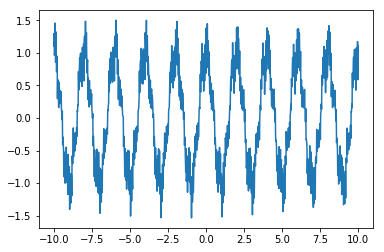

In [30]:
f = lambda t: np.cos(np.pi*t) + 0.2*np.sin(5*np.pi*t+0.1) + 0.2*np.sin(30*np.pi*t)  + 0.1*np.sin(32*np.pi*t+0.1) + 0.1*np.sin(47* np.pi*t+0.8)
t=np.linspace(-10,10,1000); signal=f(t)
print(np.shape(t),np.shape(signal))
plt.plot(t, signal)

## Q1. Implement an ideal low pass filter using Fourier transform in 1D:
### Compute the inverse FFT of a low pass filter and cut it with a window that will be passed in argument and apply it to the signal above by convolution or using FFT.


## Q2. Using the code below, implement an IIR filter defined by its numerator which will be set to a  constant $b$ and its denominator which will be set to $1-az^{-1}$. 
### What can you say about the range of the parameter $a$ in order to obtain a stable filter. 
### Experimentally, determine the ranges of $a$ to get respectively a low-pass filter and a high-pass filter. Give a theoretical explanation.

In [ ]:
def myIIR(x,a,b):
    ### a is the numerator
    ### b is the denominator
    assert(len(a)==len(b)),"a,b must have the same length"
    y = np.zeros_like(x)
    k = len(a)
    for i in range(len(a),len(x)):
        y[i] = np.sum(np.flipud(b)*y[i-k:i]) + np.sum(np.flipud(a) * x[i-k+1:i+1])
    return y

## In the following, we are given an electrocardiogram. We plot it as a function of time.

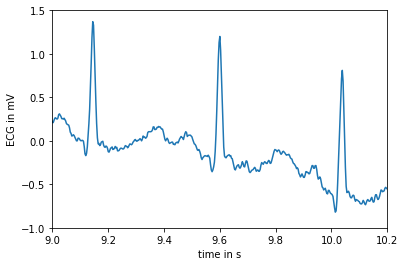

time min 0.0
time max 299.9972222222222


In [34]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2)
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])



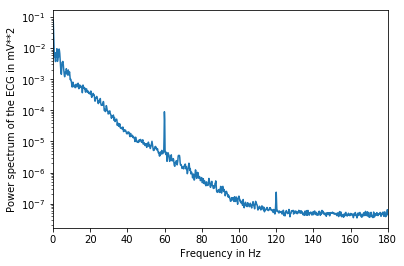

In [35]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sig.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

## Q3. Estimate the number of heartbeats in the following electrocardiogram and estimate the mean value of the interval between two heartbeats. You can use the method of your choice. A possible method consists in using a band pass filter and then extract the maximum values of the filtered signal.